### Classification model

In [1]:
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import requests
import gdown
from torchvision import models, transforms

In [2]:
model_clf = models.resnet18()
num_features = model_clf.fc.in_features
model_clf.fc = torch.nn.Linear(num_features, 2)

# pretrained weights url
url = 'https://drive.google.com/uc?id=12tmF8f8HXLcv4eX5J3-q17JOARPe8vKK'
output = 'resnet.pth'
gdown.download(url, output, quiet=False)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_clf.load_state_dict(torch.load(output, map_location=DEVICE))
model_clf.to(DEVICE)
model_clf

# doesn't work because load_from_url doesn't work for google drive large files for some reason
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# state_dict = torch.hub.load_state_dict_from_url(url="https://drive.google.com/uc?export=download&id=1R6DcpYzwtJJweWSpbIwEb0cC85aqYDMC",
#                                                 map_location=device)
# model_clf.load_state_dict(state_dict)

Downloading...
From: https://drive.google.com/uc?id=12tmF8f8HXLcv4eX5J3-q17JOARPe8vKK
To: /content/resnet.pth
100%|██████████| 44.8M/44.8M [00:01<00:00, 38.3MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Classify image

In [3]:
def predict_one_sample(model, img, device):
    """Предсказание, для одной картинки"""
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(DEVICE)
    model.eval()
    logit = model(img).cpu()
    probs = torch.nn.functional.softmax(logit, dim=-1).detach().numpy()
    return probs

In [4]:
def classify_one_image(model, img, device):
    probs = predict_one_sample(model, img, device)
    probs = np.squeeze(probs, axis=0)
    res_dict = {}
    score = probs[0] if probs[0] > 0.5 else probs[1]
    res_dict['score'] = str(round(score, 5))
    if probs[0] > 0.5:
        score = probs[0]
        res_dict['type'] = 'nevus'
        return res_dict
    else:
        res_dict['type'] = 'melanoma'
        return res_dict

In [5]:
def dict_to_str(d):
    res_str = ''
    # print(d)
    for k in d:
        res_str += f'{k}:  {d[k]}\n'

    return res_str

In [6]:
url = 'https://dermoscopy.files.wordpress.com/2014/09/benign-mole-regular-globules.jpg'
img = Image.open(requests.get(url, stream=True).raw)

In [7]:
classify_one_image(model_clf, img, DEVICE)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


{'score': '0.98222', 'type': 'nevus'}

In [8]:
predict_one_sample(model_clf, img, DEVICE)

array([[0.98222005, 0.01777996]], dtype=float32)

### Segmentation model

In [9]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True),
                                       )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True),
                                       )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.enc_conv4 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       )
        self.upsample1 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       )
        self.upsample2 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True),
                                       )
        self.upsample3 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True),
                                       )
        self.upsample4 = nn.MaxUnpool2d(2, stride=2)
        self.dec_conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
                                       )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))
        e4, ind4 = self.pool4(self.enc_conv4(e3))

        # decoder
        d0 = self.dec_conv0(self.upsample0(e4, ind4))
        d1 = self.dec_conv1(self.upsample1(d0, ind3))
        d2 = self.dec_conv2(self.upsample2(d1, ind2))
        d3 = self.dec_conv3(self.upsample3(d2, ind1))
        d4 = self.dec_conv4(self.upsample4(d3, ind0)) # no activation, no normalization, no softmax
        return d4

In [10]:
model_sgm = SegNet()
# pretrained weights url
url = 'https://drive.google.com/uc?id=14pOMVdf1l0aCfLtqSxTA9h7lLpA0tcal'
output = 'segnet.pth'
gdown.download(url, output, quiet=False)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sgm.load_state_dict(torch.load(output, map_location=DEVICE))
model_sgm.to(DEVICE)
model_sgm

Downloading...
From: https://drive.google.com/uc?id=14pOMVdf1l0aCfLtqSxTA9h7lLpA0tcal
To: /content/segnet.pth
100%|██████████| 118M/118M [00:03<00:00, 38.5MB/s]


SegNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

### Segment image

In [11]:
def segment_one_sample(model, img, device):
    """Предсказание, для одной картинки"""
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256))
            ])
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(DEVICE)
    model.eval()
    mask = torch.round(torch.sigmoid(model(img)))
    mask = mask.detach().cpu().numpy()
    mask = np.rollaxis(mask, 1, 4)
    mask = np.squeeze(mask, axis=0)
    mask = np.squeeze(mask, axis=-1)
    return mask

In [12]:
def prepare_mask(mask, size):
    img_mask = Image.fromarray((mask * 255).astype(np.uint8), mode='L')
    img_mask = img_mask.resize(size)
    bio = BytesIO()
    img_mask.save(bio, format='PNG')
    bio.seek(0)
    return bio

In [13]:
url = 'https://dermoscopy.files.wordpress.com/2014/09/benign-mole-regular-globules.jpg'
img = Image.open(requests.get(url, stream=True).raw)
size = img.size
size

(1017, 836)

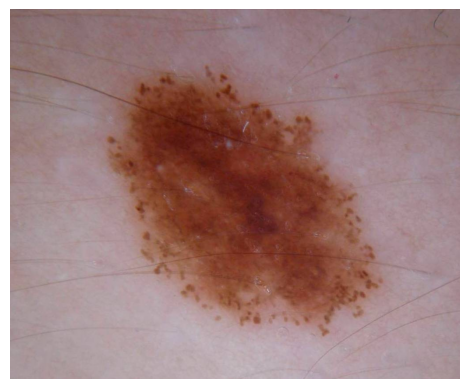

In [14]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis('off')
plt.show()

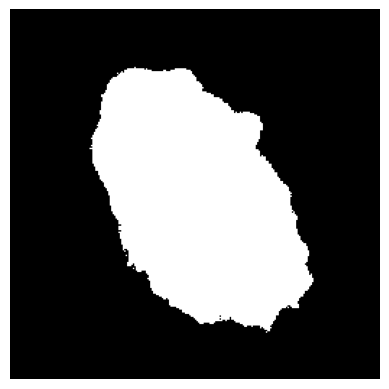

In [15]:
mask = segment_one_sample(model_sgm, img, DEVICE)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

(256, 256)
(1017, 836)


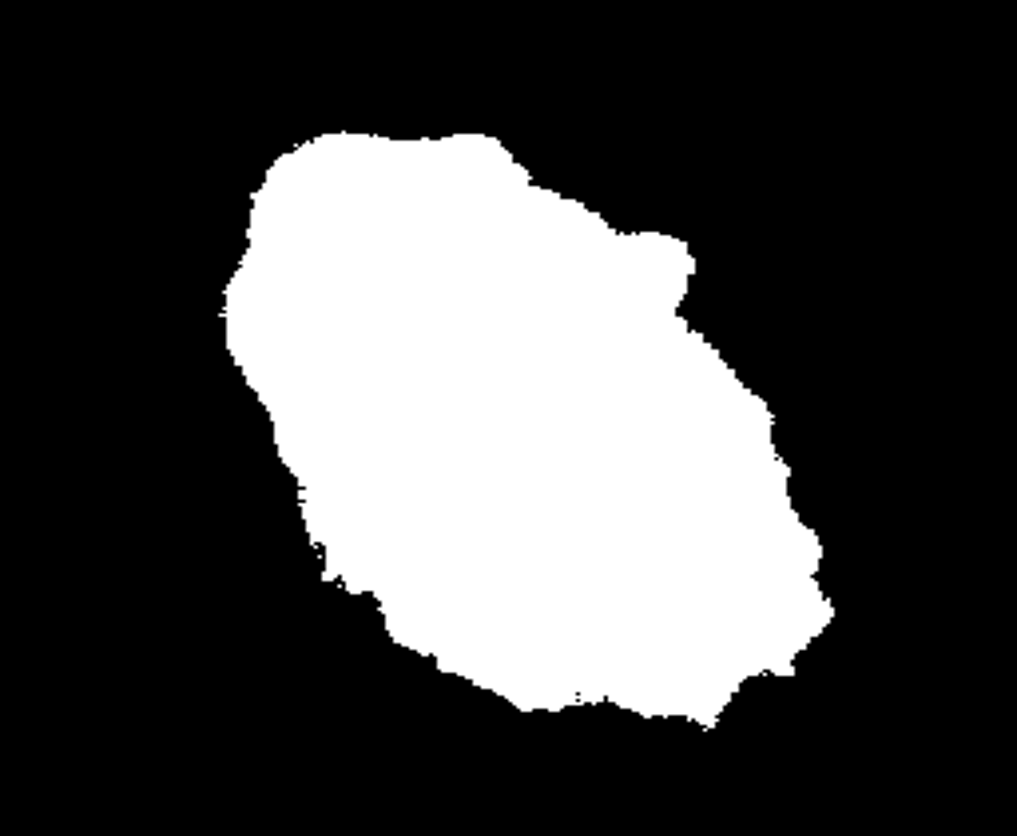

In [16]:
mask1 = (mask * 255).astype(np.uint8)
img = Image.fromarray(mask1, mode='L')
print(img.size)
img = img.resize(size)
print(img.size)
display(img)

### Telegram bot

In [17]:
!pip install pyTelegramBotAPI -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.1/243.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [18]:
import telebot
from io import BytesIO

In [19]:
token = '6846855696:AAHnHTWeCyKJC7eobidYeRkXcYWPhKtIP1Y'
bot = telebot.TeleBot(token)

@bot.message_handler(commands=['start', 'help'])
def start_message(message):
    start_message = ('This bot can segment and classify skin lesion images. '
                     'Only nevus and melanoma lesion types are supported. '
                     'Send a photo of the skin lesion.')
    bot.send_message(message.chat.id, start_message)

@bot.message_handler(content_types='text')
def message_reply(message):
    answer = 'hi'
    bot.send_message(message.chat.id, answer)

@bot.message_handler(content_types=['photo'])
def process_image(message):
    file_id = message.photo[-1].file_id
    url = bot.get_file_url(file_id)
    img = Image.open(requests.get(url, stream=True).raw)
    size = img.size
    res_dict = classify_one_image(model_clf, img, DEVICE)
    bot.send_message(message.chat.id, 'Classification result\n' + dict_to_str(res_dict))
    mask = segment_one_sample(model_sgm, img, DEVICE)
    bio = prepare_mask(mask, size)
    bot.send_photo(message.chat.id, photo=bio, caption='Segmentation mask')

bot.infinity_polling()

2023-10-25 11:58:34,909 (__init__.py:966 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
ERROR:TeleBot:Infinity polling: polling exited
2023-10-25 11:58:34,913 (__init__.py:968 MainThread) ERROR - TeleBot: "Break infinity polling"
ERROR:TeleBot:Break infinity polling
